In [1]:
# By the end of this chapter, you should be able to explain:
# 1. the role of tensors, and of broadcasting
# 2. stochastic gradient descent (SGD)
# 3. choice of loss function
# 4. role of mini-batches
# 5. math that a basic neural net is doing
# able to put these pieces together

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [6]:
(path/'train').ls()   # let's see what's inside training set

(#2) [Path('train/3'),Path('train/7')]

In [7]:
# let's look into one of these folders of 3's and 7's
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [16]:
# computer stores everything as number; 
# let's convert this image into NumPy array or PyTorch tensor and 
# see what it looks like
array(im3).shape, array(im3)[4:10, 4:10]

((28, 28),
 array([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=uint8))

In [17]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [19]:
# hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


# OUR GOAL: [ to create a model that can recognize 3's and 7's ]

In [46]:
seven_ts = [tensor(Image.open(o)) for o in sevens]
three_ts = [tensor(Image.open(o)) for o in threes]
len(seven_ts), len(three_ts)

(6265, 6131)

<Axes: >

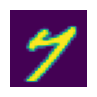

In [49]:
show_image(seven_ts[1])

In [56]:
stacked_sevens = torch.stack(seven_ts).float()/255
stacked_threes = torch.stack(three_ts).float()/255
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [57]:
stacked_threes.ndim  # tensor's rank is 3

3

<Axes: >

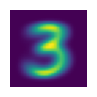

In [58]:
# let's compute the avg of a pixel over all images
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

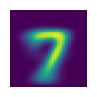

In [59]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

<Axes: >

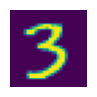

In [62]:
# let's pick an arbitrary 3 and measure its distance from our "ideal digits"
a_3 = stacked_threes[1]
show_image(a_3)

In [63]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [67]:
a_7 = stacked_sevens[1]
dist_7_abs = (a_7 - mean7).abs().mean()
dist_7_sqr = ((a_7 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1304), tensor(0.2585))

In [68]:
import torch.nn.functional as F
F.l1_loss(a_3.float(), mean3)

tensor(0.1114)

In [70]:
F.mse_loss(a_3, mean7).sqrt()

tensor(0.3021)

In [71]:
valid_3_tens = torch.stack(
    [tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]
)
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack(
    [tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]
)
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [72]:

def mnist_distance(a,b): return (a-b).abs().mean((-1, -2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [73]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

In [75]:
# 1010 28 28
#     28 28

# --------------- BROADCASTING RULES -------------------:
# - each tensor has at least one dimension
# - after shifting the dimensions to the right; 
# the dimension sizes must either be equal, one of them is 1 or doesn't exist 

In [78]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [79]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [83]:
is_3(valid_3_tens).float().mean()

tensor(0.9168)

In [81]:
accuracy_3s =      is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [85]:
is_3(a_7), is_3(a_7).float()

(tensor(False), tensor(0.))

### Stochastic Gradient Descent (SGD)

In [87]:
# initalize the weights
# make predictions based on those weights
# calculate the performance of the model; that is, calc. loss
# calculate gradient; how changing weight would change(decrease) the loss
# tweak the weights by lil amount based on calculated gradient 
# go back to step 2 and repeat the process until you are satisfied with the model performance


In [ ]:
# Initialize: we initialize the parameters to random values
# Loss: testing the effectiveness of current weight assignment in terms
#       actual performance(loss)
# Step: a simple way to figure out whether a weight is to be increased or decreased a bit
# Stop: deciding whether to train the model more or stop 

#### A simple example

In [91]:
def f(x): return x**2

In [94]:
import matplotlib.pyplot as plt
import numpy as np

def plot_function(func, x_label='x', y_label='y', title=None, range=(-10, 10), resolution=400):
    """
    Plots a mathematical function.

    Parameters:
    - func: The mathematical function to plot.
    - x_label (str): The label for the x-axis.
    - y_label (str): The label for the y-axis.
    - title (str): The title of the plot.
    - range (tuple): The range of x values to plot.
    - resolution (int): The number of points to generate between the range.
    """
    # Generate x values
    x = np.linspace(range[0], range[1], resolution)

    # Generate y values
    y = func(x)

    # Create the plot
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if title:
        plt.title(title)
    plt.show()

# Example usage
# def my_function(x):
#     return x**2

# plot_function(my_function, 'x', 'x**2', 'Plot of f(x) = x**2', range=(-10, 10))


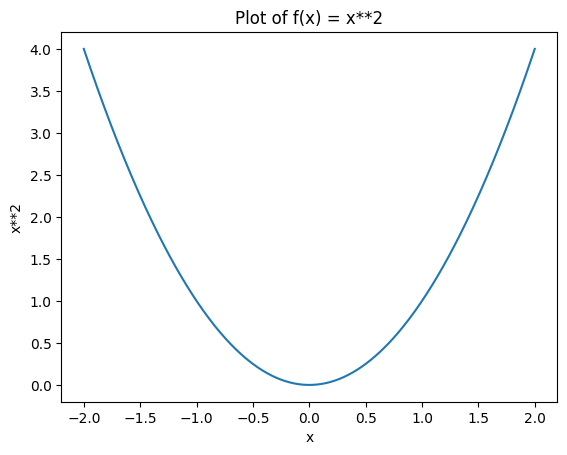

In [99]:
plot_function(f, 'x', 'x**2', 'Plot of f(x) = x**2', range=(-2, 2))

In [100]:
xt = tensor(3.).requires_grad_()

In [101]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [102]:
yt.backward()

In [103]:
xt.grad

tensor(6.)

In [104]:
xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [105]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [106]:
yt.backward()

In [108]:
xt.grad

tensor([ 6.,  8., 20.])

#### Stepping with a learning rate

In [109]:
# w -=gradient(w) * lr

# this is known as stepping your parameters, using an optimizer step

### An end-to-end SGD example

In [110]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

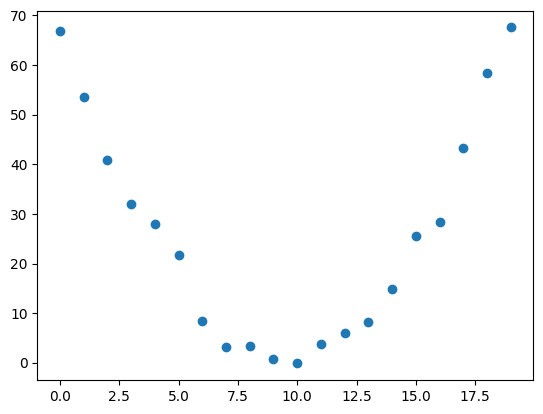

In [111]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed)

In [117]:
# we try to predict a function by observing the plotted data.
# looks like a quadratic;
# a*(t**2) + b*t + c

In [118]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + b*t + c

In [119]:
# we are trying to predict the best quadratic function to describe our data.
# which implies the best values for parameters a,b and c

# if we can do this, we can apply same approach to other complex functions

In [120]:
# for continous data it's common to use mean squared error as loss function

def mse(preds, targets): return ((preds-targets)**2).mean()

In [134]:
# Step 1: Initalize the parameters randomly
params = torch.randn(3).requires_grad_()

In [135]:
params

tensor([ 0.8157, -1.8471, -0.6651], requires_grad=True)

In [136]:
#hide
orig_params = params.clone()

In [137]:
# Step 2: make predictions with intialized parameters
preds = f(time, params)

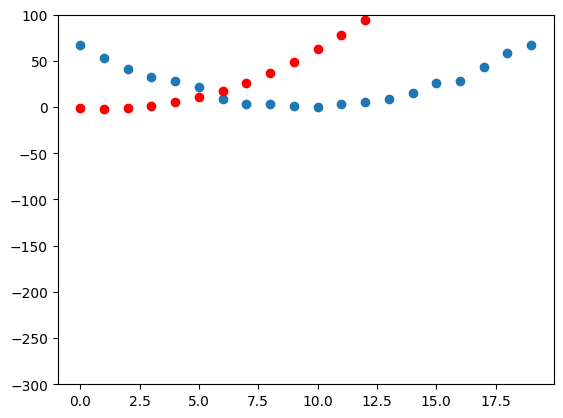

In [138]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

show_preds(preds)

In [139]:
# Step 3: Calculate the loss
loss = mse(preds, speed)
loss

tensor(9423.5078, grad_fn=<MeanBackward0>)

In [140]:
# Step 4: calculate the gradients
loss.backward()
params.grad

tensor([31392.7402,  1986.1914,   113.5754])

In [141]:
params.grad * 1e-5

tensor([0.3139, 0.0199, 0.0011])

In [142]:
params

tensor([ 0.8157, -1.8471, -0.6651], requires_grad=True)

In [143]:
# Step 5: step the weights
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [145]:
preds = f(time, params)
mse(preds, speed)

tensor(2324.0813, grad_fn=<MeanBackward0>)

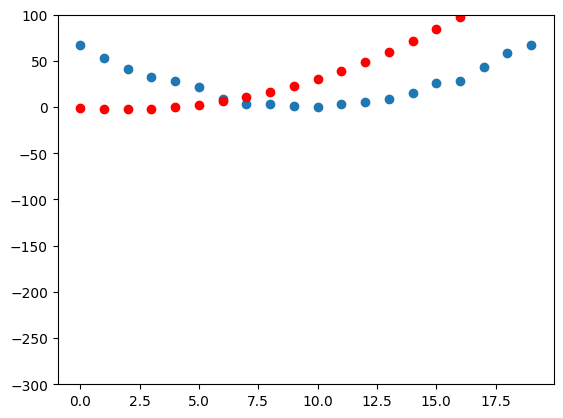

In [146]:
show_preds(preds)

In [151]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [149]:
# Step 6: Repeat the process

In [152]:
for i in range(10): apply_step(params)

2324.081298828125
980.6414794921875
726.4104614257812
678.290771484375
669.1737060546875
667.4370727539062
667.0971069335938
667.021484375
666.995849609375
666.979736328125


In [154]:
#hide 
params = orig_params.detach().requires_grad_()

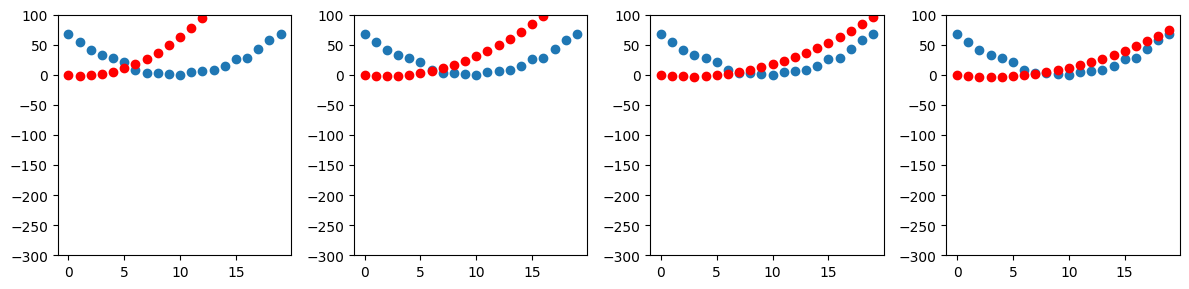

In [155]:
_, axs = plt.subplots(1,4, figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

In [156]:
# Step 7: Stop

## MNIST Loss Function

In [160]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

In [164]:
# we need label for each image; we use 1 for 3s and 0 for 7s
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [174]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [175]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [176]:
# we need to initialize weights randomly for every pixel
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [177]:
weights = init_params((28*28, 1))
weights.shape

torch.Size([784, 1])

In [180]:
# bias
bias = init_params(1)
bias

tensor([-1.5117], requires_grad=True)

In [181]:
# y = w*x + b
(train_x[0]*weights.T).sum() + bias

tensor([9.7979], grad_fn=<AddBackward0>)

In [206]:
(train_x[0]*weights).shape

torch.Size([784, 784])

In [208]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds, preds.shape

(tensor([[ 9.7979],
         [ 2.7399],
         [ 2.1788],
         ...,
         [-2.8513],
         [20.1345],
         [ 4.6138]], grad_fn=<AddBackward0>),
 torch.Size([12396, 1]))

In [209]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [False],
        [False]])

In [211]:
corrects.float().mean().item()

0.3034043312072754

In [212]:
# change in accuracy for a small change in weights
with torch.no_grad(): weights[0] *= 1.0001

In [213]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.3034043312072754

In [218]:
corrects.float().mean()

tensor(0.3034)

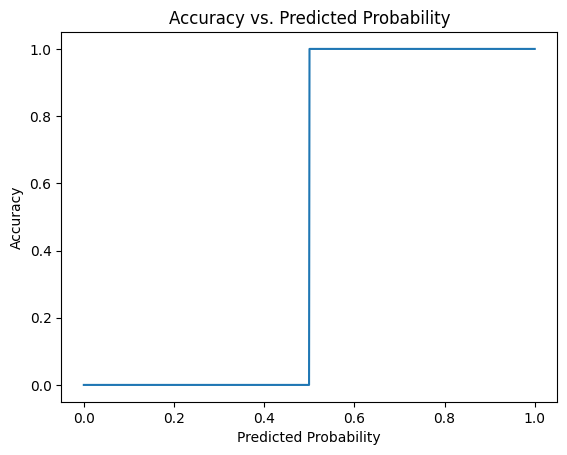

In [219]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated probability scores
probabilities = np.linspace(0, 1, 1000)

# Accuracy function using 0.5 as threshold
accuracy = np.where(probabilities > 0.5, 1, 0)

# Plot
plt.plot(probabilities, accuracy)
plt.title("Accuracy vs. Predicted Probability")
plt.xlabel("Predicted Probability")
plt.ylabel("Accuracy")
plt.show()
